In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip drive/MyDrive/data/GAN/06.04-orig.zip > /dev/null

In [4]:
!unzip drive/MyDrive/data/GAN/11.03.zip > /dev/null

In [5]:
codings_size = 100
batch_size = 32
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
path = glob.glob("./OK/*.jpg")
print(len(path))
def get_train_images():
   for i, file in enumerate(path):
     if i % 5 != 0:
       img = plt.imread(file)
       img = img[30:-50]
       img = cv2.resize(img , (256,256))
       img = img / 255. * 2. - 1.
       yield img

def get_valid_images():
   for i, file in enumerate(path):
     if i % 5 == 0:
       img = plt.imread(file)
       img = img[30:-50]
       img = cv2.resize(img , (256,256))
       img = img / 255. * 2. - 1.
       yield img

train_dataset = tf.data.Dataset.from_generator(get_train_images, output_types=(tf.float32))
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

val_dataset = tf.data.Dataset.from_generator(get_valid_images, output_types=(tf.float32))
val_dataset = val_dataset.shuffle(1000)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

len_valid = int(len(path) / 5)
len_train = len(path) - len_valid 
NO_OF_TRAIN_BATCHES= int(len_train / batch_size)
NO_OF_VAL_BATCHES= int(len_valid / batch_size)

print(NO_OF_TRAIN_BATCHES)
print(NO_OF_VAL_BATCHES)

38801
970
242


In [4]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        image = (image + 1.) / 2.
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [5]:
def train_gan(gan, train_dataset, val_dataset, batch_size, codings_size, n_epochs=1000):
    generator, discriminator = gan.layers
    disc_metrics=[]
    gan_metrics=[]
    disc_val_metrics=[]
    gan_val_metrics=[]
    
    ## Training
    for i, epoch in enumerate(range(n_epochs)):
      disc_metrics_per_epoch=[]
      gan_metrics_per_epoch=[]
      print("\nEpoch {}/{}".format(epoch + 1, n_epochs))
      for j,  X_batch in enumerate(tqdm(train_dataset, total= NO_OF_TRAIN_BATCHES)):
          # gan.reset_metrics()
          X_batch = tf.cast(X_batch, tf.float32)
          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          logs= discriminator.train_on_batch(X_fake_and_real, y1)
          disc_metrics_per_epoch.append(logs)
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          logs= gan.train_on_batch(noise, y2)
          gan_metrics_per_epoch.append(logs)
      disc_metrics_per_epoch = np.mean(disc_metrics_per_epoch, axis=0)
      gan_metrics_per_epoch = np.mean(gan_metrics_per_epoch, axis=0)
      print("Disc: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}\nGAN: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}".format(
          disc_metrics_per_epoch[0], disc_metrics_per_epoch[1], disc_metrics_per_epoch[2], gan_metrics_per_epoch[0], gan_metrics_per_epoch[1], gan_metrics_per_epoch[2])
      )

      ## validation
      disc_val_metrics_per_epoch =[]
      gan_val_metrics_per_epoch =[]
      print("Validation: ")
      y_test = tf.constant([[1.]] * batch_size)
      for X_batch in tqdm(val_dataset, total= NO_OF_VAL_BATCHES):
         noise = tf.random.normal(shape=[batch_size, codings_size])
         disc_logs= discriminator.test_on_batch(X_batch, y_test)
         disc_val_metrics_per_epoch.append(disc_logs)
         gan_logs= gan.test_on_batch(noise, y_test)
         gan_val_metrics_per_epoch.append(gan_logs)
      disc_val_metrics_per_epoch = np.mean(disc_val_metrics_per_epoch, axis=0)
      gan_val_metrics_per_epoch = np.mean(gan_val_metrics_per_epoch, axis=0)
      print("Disc: val_loss= {:.4f}, val_mae= {:.4f}, val_acc= {:.4f}\nGAN: val_loss= {:.4f}, val_mae= {:.4f}, val_acc= {:.4f}".format(
          disc_val_metrics_per_epoch[0], disc_val_metrics_per_epoch[1], disc_val_metrics_per_epoch[2], gan_val_metrics_per_epoch[0], gan_val_metrics_per_epoch[1], gan_val_metrics_per_epoch[2])
      )

      gan.save("./drive/MyDrive/models/GAN/GAN-6-4-2/gan_6_4_2{}.hdf5".format(i))
      plot_multiple_images(generated_images, 8)
      plt.show()
      disc_metrics.append(disc_metrics_per_epoch)
      gan_metrics.append(gan_metrics_per_epoch)
      disc_val_metrics.append(disc_val_metrics_per_epoch)
      gan_val_metrics.append(gan_val_metrics_per_epoch)
    return disc_metrics, gan_metrics, disc_val_metrics, gan_val_metrics

In [6]:
generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[256, 256, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [7]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                        

In [8]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])


Epoch 1/5


100%|██████████| 970/970 [04:09<00:00,  3.89it/s]


Disc: loss= 0.0784, mae= 0.0413, acc= 0.9706
GAN: loss= 5.0329, mae= 0.5729, acc= 0.4202
Validation: 


100%|██████████| 242/242 [00:41<00:00,  5.89it/s]


Disc: val_loss= 0.0026, val_mae= 0.0025, val_acc= 0.9999
GAN: val_loss= 0.8749, val_mae= 0.4779, val_acc= 0.5446


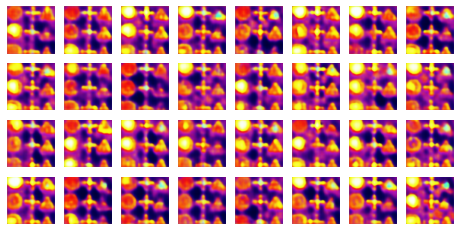


Epoch 2/5


100%|██████████| 970/970 [04:08<00:00,  3.91it/s]


Disc: loss= 0.1863, mae= 0.1128, acc= 0.9291
GAN: loss= 2.6971, mae= 0.7222, acc= 0.2402
Validation: 


100%|██████████| 242/242 [00:40<00:00,  5.93it/s]


Disc: val_loss= 0.0004, val_mae= 0.0004, val_acc= 1.0000
GAN: val_loss= 0.0496, val_mae= 0.0412, val_acc= 0.9916


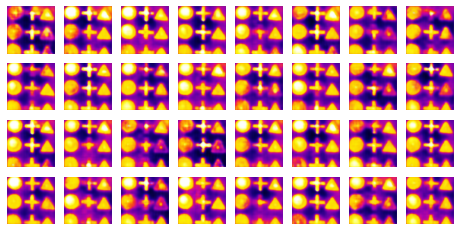


Epoch 3/5


100%|██████████| 970/970 [04:09<00:00,  3.89it/s]


Disc: loss= 0.2503, mae= 0.1479, acc= 0.9006
GAN: loss= 2.5475, mae= 0.7057, acc= 0.2578
Validation: 


100%|██████████| 242/242 [00:41<00:00,  5.88it/s]


Disc: val_loss= 0.0010, val_mae= 0.0005, val_acc= 0.9999
GAN: val_loss= 0.0607, val_mae= 0.0555, val_acc= 0.9974


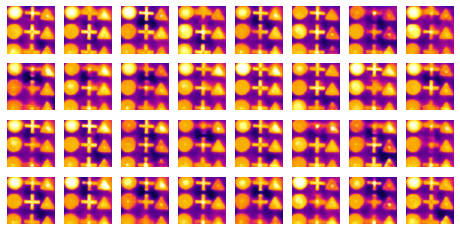


Epoch 4/5


100%|██████████| 970/970 [04:08<00:00,  3.90it/s]


Disc: loss= 0.3176, mae= 0.1837, acc= 0.8717
GAN: loss= 2.2127, mae= 0.6648, acc= 0.2976
Validation: 


100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Disc: val_loss= 0.0038, val_mae= 0.0027, val_acc= 0.9991
GAN: val_loss= 0.2432, val_mae= 0.1794, val_acc= 0.9090


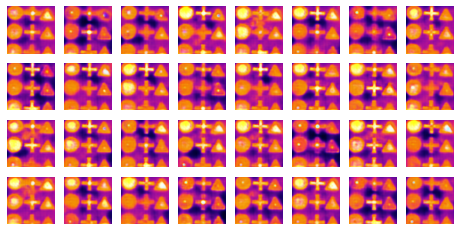


Epoch 5/5


100%|██████████| 970/970 [04:07<00:00,  3.92it/s]


Disc: loss= 0.3205, mae= 0.1846, acc= 0.8658
GAN: loss= 2.3708, mae= 0.7187, acc= 0.2420
Validation: 


100%|██████████| 242/242 [00:40<00:00,  5.96it/s]


Disc: val_loss= 0.0197, val_mae= 0.0145, val_acc= 0.9924
GAN: val_loss= 0.1687, val_mae= 0.1247, val_acc= 0.9412


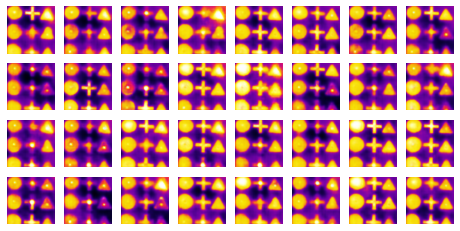

In [9]:
disc_metrics, gan_metrics, disc_val_metrics, gan_val_metrics = train_gan(gan, train_dataset, val_dataset, batch_size, codings_size, n_epochs= 5)

In [ ]:
d = np.asarray(d_metrics)
g = np.asarray(g_metrics) 
plt.plot(d[:, 2])
plt.plot(g[:, 2])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Discriminator', 'GAN'], loc='lower right')
plt.show()

In [6]:
discriminator_0  = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4-2/gan_6_4_20.hdf5").layers[1]
discriminator_1  = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4-2/gan_6_4_21.hdf5").layers[1]
discriminator_2  = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4-2/gan_6_4_22.hdf5").layers[1]
discriminator_3  = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4-2/gan_6_4_23.hdf5").layers[1]
discriminator_4 = keras.models.load_model("drive/MyDrive/models/GAN/GAN-6-4-2/gan_6_4_24.hdf5").layers[1]

In [7]:
discriminator_0.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator_2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator_3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator_4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])

100%|██████████| 393/393 [00:14<00:00, 28.01it/s] 


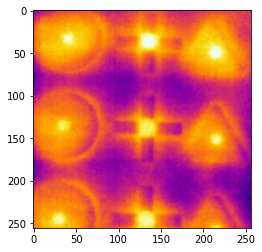

In [12]:
## Normal images
path = glob.glob("./OK/*.jpg")
count = 0 
images_OK = []
for i, file in enumerate(tqdm(path)):
   if i % 10 ==0:
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256,256))
    image = img  / 255. * 2. - 1.
    images_OK.append(image)
    count += 1
plt.imshow(img)
images_OK = np.asarray(images_OK)

y_test_ok = tf.constant([[1.]] * count)

## defekt images
path = glob.glob("./DEF/*.jpg")
y_test_def = tf.constant([[0.]] * len(path))
images_DEF = []
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256,256))
    image = img  / 255. * 2. - 1.
    images_DEF.append(image)
plt.imshow(img)
images_DEF = np.asarray(images_DEF)

In [13]:
y_test_ok = tf.constant([[1.]] * count)
np.shape(images_OK)
np.shape(y_test_ok)

TensorShape([3881, 1])

In [14]:
discriminator_0.evaluate(images_OK, y_test_ok)
discriminator_1.evaluate(images_OK, y_test_ok)
discriminator_2.evaluate(images_OK, y_test_ok)
discriminator_3.evaluate(images_OK, y_test_ok)
discriminator_4.evaluate(images_OK, y_test_ok)

discriminator_0.evaluate(images_DEF, y_test_def)
discriminator_1.evaluate(images_DEF, y_test_def)
discriminator_2.evaluate(images_DEF, y_test_def)
discriminator_3.evaluate(images_DEF, y_test_def)
discriminator_4.evaluate(images_DEF, y_test_def)

13/13 [==============================] - 0s 15ms/step - loss: 0.2285 - mae: 0.1722 - accuracy: 0.8855


[0.22851085662841797, 0.17216098308563232, 0.885496199131012]

In [ ]:
y_20  = discriminator_20.predict(images)
y_40=   discriminator_40.predict(images)
y_60=   discriminator_60.predict(images)
y_80=   discriminator_80.predict(images)
y_100= discriminator_100.predict(images)
y_120= discriminator_120.predict(images)
y_140= discriminator_140.predict(images)
y_140= discriminator_140.predict(images)

100%|██████████| 2009/2009 [00:48<00:00, 41.32it/s] 


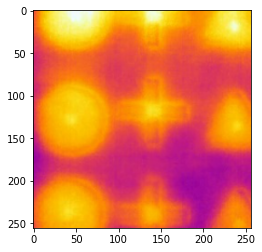

In [8]:
## Normal images
path = glob.glob("./0/*.jpg")
count = 0 
images_OK = []
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256,256))
    image = img  / 255. * 2. - 1.
    images_OK.append(image)
    count += 1
plt.imshow(img)
images_OK = np.asarray(images_OK)

y_test_ok = tf.constant([[1.]] * count)

## defekt images
path = glob.glob("./1/*.jpg")
y_test_def = tf.constant([[0.]] * len(path))
images_DEF = []
for i, file in enumerate(tqdm(path)):
    img = plt.imread(file)
    img = img[30:-50]
    img = cv2.resize(img, (256,256))
    image = img  / 255. * 2. - 1.
    images_DEF.append(image)
plt.imshow(img)
images_DEF = np.asarray(images_DEF)

In [9]:
discriminator_0.evaluate(images_OK, y_test_ok)
discriminator_1.evaluate(images_OK, y_test_ok)
discriminator_2.evaluate(images_OK, y_test_ok)
discriminator_3.evaluate(images_OK, y_test_ok)
discriminator_4.evaluate(images_OK, y_test_ok)

discriminator_0.evaluate(images_DEF, y_test_def)
discriminator_1.evaluate(images_DEF, y_test_def)
discriminator_2.evaluate(images_DEF, y_test_def)
discriminator_3.evaluate(images_DEF, y_test_def)
discriminator_4.evaluate(images_DEF, y_test_def)

63/63 [==============================] - 5s 72ms/step - loss: 1.0401e-04 - mae: 1.0397e-04 - accuracy: 1.0000


[0.00010401343024568632, 0.00010396990546723828, 1.0]